<a href="https://colab.research.google.com/github/TheDon57/MODS_Exercises/blob/main/Week_11_exercise/Topic_Modeling_Week_11_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

## Introduction

In this weeks tutorial we will work with __Topic modeling__, which is an __unsupervised__ method for text analysis. As manual annotation of data is very time-consuming, naturally there is much more raw than annotated data.
But we already know one method to analyze unlabeled data: __Clustering__. Topic modeling is a special case of clustering and is theoretically based on the "Distributional hypothesis of linguistics" which states that words that co-occur together in similar contexts tend to have similar meanings. Additionally these co-occurrence patterns can be interpreted as topics and used to cluster documents.

We are still working with the same dataset as before (IMDB) and since this dataset contains annotations (sentiment scores), we will finally use the created topic model as new features for predicting the sentiment.

## Data

The dataset we will use contains movie reviews from IMDB. Initially the data is stored as a dataframe with three columns (id, sentiment_human, text).

*Run the code below.*

In [2]:
import pandas as pd
#Loading the data from a csv file
reviews = pd.read_csv("https://raw.githubusercontent.com/kbrennig/MODS_WS25_26/refs/heads/main/data/imdb_sample.csv")

### Prepare data for classifier

For our classifier we only need the ground truth sentiment_score (which we again recode from 'positive'/'negative' to 1/0) and the topic columns.

*Run the code below.*

In [3]:
reviews['sentiment_positive'] = np.where(reviews['sentiment_human'] == 'positive', 1, 0)

### Split Dataset into Train- and Testset

Similar to the weeks before, we create a train- and testset so that we can later use the topics as input for a machine learning model.

*Run the code below.*

In [4]:
from sklearn.model_selection import train_test_split

#define X and y
X = reviews.drop(columns=['id','sentiment_human','sentiment_positive'])
y = reviews['sentiment_positive']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Preprocessing

Since unstructured data doesn't have an inherent and consistent structure we have to perform some preprocessing steps in order to make the data usable for the computer.
One thing to keep in mind is that the more preprocessing we perform the more information we lose, but the basic methods we are using here require it.

### Tokenize documents
First, we tokenize the texts. This means we transform the texts from one long string to a list of tokens. Additionally we also start removing unwanted characters (e.g punctuation between sentences, numbers, etc.).
For a full list and explanation of the used parameters you can have a look at the documentation.

In the code, we use `nltk.word_tokenize(text)` to break the input text into individual words or tokens. This is the first step in preprocessing, as computers need to work with smaller units rather than entire sentences.

### Stem all words
After tokenizing the texts we perform stemming (alternatively lemmatization could be performed). Stemming reduces every word to its stem.
The stemmer we use here is the Porter Stemmer.

Here, we create a `PorterStemmer` object from NLTK. Then, for each token, we apply `stemmer.stem(token)` to reduce words to their root form. For example, "running", "runs", and "ran" might all be reduced to "run". This helps in grouping similar words together, making the analysis more consistent.

### Remove stopwords
Finally we remove words that don't contain real meaning and are commonly used (e.g. 'this', 'the', 'a', etc.).

We get a list of English stopwords using `nltk.corpus.stopwords.words("english")`. Then, we filter out any stemmed tokens that are in this list (case-insensitive). Stopwords are common words that don't carry much sentiment or meaning, so removing them reduces noise in the data.

### Remove punctuation
Additionally, we remove any remaining punctuation marks from the filtered tokens. This is done by checking if each token is not in `string.punctuation`, which contains common punctuation characters like '.', ',', '!', etc. This further cleans the text by eliminating non-alphabetic characters that aren't useful for sentiment analysis.

The function `preprocess(text)` combines all these steps and returns a list of cleaned, stemmed tokens without stopwords or punctuation.

*Run the code below.*

In [5]:
# Preprocessing
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# Download the punkt resource
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Define function with all necessary preprocessing steps for our IMDB reviews. As in week 9 we now use Stemming again.
def preprocess(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # create stemmer object
    stemmer = nltk.stem.PorterStemmer()

    # stem each token
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # get list of stopwords in English
    stopwords = nltk.corpus.stopwords.words("english")

    # remove stopwords
    filtered_tokens = [token for token in stemmed_tokens if token.lower() not in stopwords]

    # remove punctuation. Here we use another kind of removing punctuation compared to last week. The Regex-based removal also removes punctuation attached to words (e.g., "hello," or "test.")
    filtered_tokens_nopunct = [re.sub(r'[^\w\s]', '', token) for token in filtered_tokens if token]

    return filtered_tokens_nopunct


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Apply preprocessing

After defining the preprocessing function, we now apply it to our training and test datasets. This step transforms the raw text in the 'text' column into a list of cleaned, stemmed tokens without stopwords or punctuation.

Running the code below applies the `preprocess` function to each review in the 'text' column of both `X_train` and `X_test`. The results are stored in a new column called 'tokens'. Finally, we display the first processed review to verify the output.

This preprocessing is crucial because topic modeling algorithms like LDA work with tokenized text, and removing noise (stopwords, punctuation) helps in identifying meaningful topics.

In [6]:
# Apply text preprocessing
# Preprocess text data
X_train['tokens'] = X_train['text'].apply(preprocess)
X_test['tokens'] = X_test['text'].apply(preprocess)

X_train['tokens'].iloc[0]  # Display first processed review

['realli',
 'want',
 'watch',
 'thi',
 'one',
 '',
 'seem',
 'old',
 'raj',
 'kanwar',
 'movi',
 'disgust',
 'even',
 'befor',
 'start',
 'watch',
 'becaus',
 'nt',
 'consid',
 'even',
 'close',
 'mediocr',
 'filmmak',
 '',
 'onli',
 'reason',
 'took',
 'thi',
 'one',
 'obvious',
 'shahrukh',
 'khan',
 'appear',
 'film',
 '',
 'even',
 'known',
 'film',
 'wa',
 'becaus',
 'wa',
 'sure',
 'would',
 'ordinari',
 'fairi',
 'tale',
 '',
 'imagin',
 'love',
 'stori',
 'shahrukh',
 'khan',
 'divya',
 'bharti',
 'substanti',
 'support',
 'role',
 'rishi',
 'kapoor',
 'thought',
 'would',
 'play',
 'father',
 'uncl',
 '',
 'complet',
 'shock',
 '',
 'rishi',
 'kapoor',
 'actual',
 'hero',
 '',
 'one',
 'romanc',
 'young',
 'divya',
 '',
 'wa',
 'sadden',
 'find',
 'shahrukh',
 'small',
 'part',
 'substanc',
 '',
 'onli',
 'second',
 'part',
 'thi',
 'idiot',
 'film',
 '',
 'br',
 '',
 '',
 '',
 'br',
 '',
 '',
 'let',
 'repeat',
 'question',
 '',
 'whi',
 'would',
 '17',
 'yearold',
 'love',
 

### Remove irrelevant words
In this case, we manually remove specific words that are irrelevant to the analysis. The words we want to remove are "movie" and "film". As we already performed preprocessing and stemmed the original tokens, we also need to use the stemmed version of these two words.

As the preprocess function returns a list of tokens instead an entire string, we can't use the replace function from Week 10. The replace function won't work as expected because it doesn't operate on individual elements within lists or substrings within strings. Instead, we need to process each list individually. The code below uses the apply function to iterate through each list in the column and filters out the unwanted tokens.

*Run the code below.*

In [7]:
# Remove additional irrelevant words (movie, film).
X_train['tokens'] = X_train['tokens'].apply(lambda tokens: [token for token in tokens if token not in {'movi', 'film'}])
X_test['tokens'] = X_test['tokens'].apply(lambda tokens: [token for token in tokens if token not in {'movi', 'film'}])

X_train['tokens'].iloc[0]

['realli',
 'want',
 'watch',
 'thi',
 'one',
 '',
 'seem',
 'old',
 'raj',
 'kanwar',
 'disgust',
 'even',
 'befor',
 'start',
 'watch',
 'becaus',
 'nt',
 'consid',
 'even',
 'close',
 'mediocr',
 'filmmak',
 '',
 'onli',
 'reason',
 'took',
 'thi',
 'one',
 'obvious',
 'shahrukh',
 'khan',
 'appear',
 '',
 'even',
 'known',
 'wa',
 'becaus',
 'wa',
 'sure',
 'would',
 'ordinari',
 'fairi',
 'tale',
 '',
 'imagin',
 'love',
 'stori',
 'shahrukh',
 'khan',
 'divya',
 'bharti',
 'substanti',
 'support',
 'role',
 'rishi',
 'kapoor',
 'thought',
 'would',
 'play',
 'father',
 'uncl',
 '',
 'complet',
 'shock',
 '',
 'rishi',
 'kapoor',
 'actual',
 'hero',
 '',
 'one',
 'romanc',
 'young',
 'divya',
 '',
 'wa',
 'sadden',
 'find',
 'shahrukh',
 'small',
 'part',
 'substanc',
 '',
 'onli',
 'second',
 'part',
 'thi',
 'idiot',
 '',
 'br',
 '',
 '',
 '',
 'br',
 '',
 '',
 'let',
 'repeat',
 'question',
 '',
 'whi',
 'would',
 '17',
 'yearold',
 'love',
 'divya',
 'fallen',
 '40plu',
 'long

## Topic Modeling

In this section you will learn how to use topic modeling as an unsupervised method to analyse text data.

### Prepare the tokens

Before we can apply topic modeling algorithms like LDA, we need to convert our preprocessed tokens into a numerical format that the algorithm can understand. This involves creating a **dictionary** (a mapping of words to unique IDs) and a **corpus** (a collection of documents represented as bag-of-words vectors).

We first build a dictionary using `dictionary = corpora.Dictionary(X_train['tokens'])`, assigning each unique word an integer ID.

Then, we filter the dictionary with `dictionary.filter_extremes(no_below=5)` to remove words that appear in fewer than 5 documents, reducing noise and focusing on meaningful terms.

Next, we convert each document's list of tokens into a bag-of-words format using `corpus_train = [dictionary.doc2bow(text) for text in X_train['tokens']]`, where each word is represented by its ID and frequency. This is done for both the training and test sets with `corpus_test = [dictionary.doc2bow(text) for text in X_test['tokens']]`.

**Why do we do this?** Topic modeling algorithms require input as numerical vectors showing word frequencies per document. The dictionary ensures consistent word-to-ID mapping, and filtering improves model quality by removing rare words. This preparation is essential for Gensim's LDA model to learn topics from the text data.

*Run the code below.*

In [8]:
!pip install gensim
from gensim import corpora

# Create dictionary and corpus for Gensim
dictionary = corpora.Dictionary(X_train['tokens'])
dictionary.filter_extremes(no_below=5)

#the corpus shows which token appears how often in one review which can be used as input for the Topic Model
corpus_train = [dictionary.doc2bow(text) for text in X_train['tokens']]
corpus_test = [dictionary.doc2bow(text) for text in X_test['tokens']]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.4 MB/s eta 0:00:00


### Generate topic model (10 topics)

After preparing our dataset, we can now calculate the topic model. We are aiming to find 10 topics in our corpus. This value can be found through an iterative process, where you start with a number topics and then evaluate the resulting topic model (are topics to close to each other or even overlapping?, are multiple topics contained within one big topic?) and adjust the number accordingly.

We first define the number of topics we want to create. With `k=10` we aim to define 10 topics in the data.

Then, we create and train `model_10` using `LdaModel(corpus=corpus_train, num_topics=k, id2word=dictionary, iterations=100, random_state=42)`, where `corpus=corpus_train` provides the bag-of-words data, `num_topics=k` specifies 10 topics, `id2word=dictionary` maps word IDs back to words, `iterations=100` sets the number of training iterations for convergence, and `random_state=42` ensures reproducibility.

**Why do we do this?** LDA (Latent Dirichlet Allocation) is an unsupervised algorithm that discovers hidden topics in the text by analyzing word co-occurrences. It assumes documents are mixtures of topics, and topics are mixtures of words. Training with multiple iterations helps the model learn better topic distributions.

*Run the code below.*

In [9]:
from gensim.models.ldamodel import LdaModel

# Train LDA model
k=10
model_10 = LdaModel(corpus=corpus_train, num_topics=k, id2word = dictionary, iterations=100, random_state=42)


### Explore model
We can also explore the topic model by looking at the top words per topic.

*Run the code below.*

In [10]:
# Explore the topic model by printing the topics
for topic_id, topic in model_10.print_topics(num_topics=10, num_words=10):
    print(f"Topic {topic_id + 1}: {topic}")


Topic 1: 0.008*"time" + 0.006*"hi" + 0.006*"charact" + 0.006*"watch" + 0.006*"stori" + 0.005*"see" + 0.005*"would" + 0.005*"make" + 0.005*"ha" + 0.005*"good"
Topic 2: 0.007*"veri" + 0.006*"even" + 0.006*"charact" + 0.006*"time" + 0.006*"make" + 0.006*"scene" + 0.006*"good" + 0.005*"think" + 0.005*"ha" + 0.005*"doe"
Topic 3: 0.010*"would" + 0.008*"good" + 0.008*"time" + 0.007*"veri" + 0.007*"get" + 0.006*"show" + 0.006*"stori" + 0.006*"realli" + 0.006*"think" + 0.006*"even"
Topic 4: 0.007*"see" + 0.007*"watch" + 0.006*"get" + 0.006*"make" + 0.006*"time" + 0.005*"hi" + 0.005*"stori" + 0.005*"charact" + 0.005*"veri" + 0.005*"act"
Topic 5: 0.017*"hi" + 0.008*"ha" + 0.006*"good" + 0.006*"would" + 0.006*"charact" + 0.005*"watch" + 0.005*"time" + 0.005*"make" + 0.005*"great" + 0.005*"even"
Topic 6: 0.009*"time" + 0.009*"make" + 0.007*"ha" + 0.007*"onli" + 0.006*"hi" + 0.006*"would" + 0.006*"show" + 0.004*"thing" + 0.004*"charact" + 0.004*"could"
Topic 7: 0.018*"hi" + 0.006*"ha" + 0.006*"veri"

#### Topic Prevalence

We can also have a closer look at the *overall topic prevalence*, which helps prioritize the most dominant topics in the corpus. This is particularly useful for:

1. Understanding the overall themes in your dataset.
2. Identifying which topics have the most impact.

First we get an overview of how the topics are distributed over all reviews.

Here, the code computes the topic distribution for each document in the training corpus using `topic_distribution = [model_10.get_document_topics(bow) for bow in corpus_train]`, which returns a list of lists, where each inner list contains (topic_id, probability) pairs for that document. Then, it loops through each document's distribution and prints the review number, followed by each topic's ID (adjusted to 1-based) and its probability (formatted to 4 decimal places).

**Why do we do this?** This provides an overview of how topics are mixed in each review. Since LDA assumes documents are mixtures of topics, seeing the probability distributions helps understand the model's output. It allows to inspect if the topics make sense and if documents are dominated by certain topics, aiding in model evaluation and interpretation.

*Run the code below.*

In [11]:
# Get topic distributions for all reviews
topic_distribution = [model_10.get_document_topics(bow) for bow in corpus_train]

#print topic distributions for all reviews to get an overview
for i, doc_distribution in enumerate(topic_distribution):
    print(f"Review {i+1}:")
    for topic_id, prob in doc_distribution:
        print(f"  Topic {topic_id+1}: {prob:.4f}")
    print("\n")

Review 1:
  Topic 5: 0.9949


Review 2:
  Topic 3: 0.9875


Review 3:
  Topic 2: 0.4448
  Topic 3: 0.3802
  Topic 9: 0.1652


Review 4:
  Topic 4: 0.9887


Review 5:
  Topic 2: 0.9653


Review 6:
  Topic 5: 0.9889


Review 7:
  Topic 3: 0.3512
  Topic 5: 0.5018
  Topic 10: 0.1324


Review 8:
  Topic 3: 0.2533
  Topic 5: 0.7338


Review 9:
  Topic 1: 0.9785
  Topic 5: 0.0119


Review 10:
  Topic 8: 0.5183
  Topic 9: 0.4657


Review 11:
  Topic 1: 0.9933


Review 12:
  Topic 2: 0.5896
  Topic 5: 0.3670
  Topic 7: 0.0356


Review 13:
  Topic 3: 0.1262
  Topic 6: 0.8627


Review 14:
  Topic 2: 0.8254
  Topic 3: 0.1692


Review 15:
  Topic 2: 0.8332
  Topic 9: 0.1560


Review 16:
  Topic 8: 0.9742


Review 17:
  Topic 3: 0.3157
  Topic 10: 0.6637


Review 18:
  Topic 2: 0.4217
  Topic 3: 0.4002
  Topic 10: 0.1684


Review 19:
  Topic 5: 0.9833


Review 20:
  Topic 2: 0.9460
  Topic 9: 0.0477


Review 21:
  Topic 3: 0.1861
  Topic 10: 0.8066


Review 22:
  Topic 2: 0.8222
  Topic 5: 0.1686



We can also take a closer look at which reviews are most strongly associated with a specific topic.

*Run the code below.*

In [29]:
topic_id = 3  # For example, Topic 9 (adjust for zero-based indexing)
n = 4  # Number of top documents to retrieve

# Store document relevance scores
doc_scores = []

# Extract the probability for the target topic
for i, doc_distribution in enumerate(topic_distribution):
    topic_prob = dict(doc_distribution).get(topic_id, 0)
    doc_scores.append((i, topic_prob))

# Sort documents by their relevance to the target topic
sorted_docs = sorted(doc_scores, key=lambda x: x[1], reverse=True)

# Get the top `n` documents
top_docs = sorted_docs[:n]

# Print the results
print(f"Top {n} documents for Topic {topic_id+1}:")
for doc_index, prob in top_docs:
    print(f"Document {doc_index+1}: Score = {prob:.4f}")
    print(f"Text: {X_train['text'][doc_index]}")
    print("\n")

Top 4 documents for Topic 4:
Document 150: Score = 0.9959
Text: One question that must be asked immediately is: Would this film have been made if the women in it were not the aunt and cousin of Jacqueline Lee Bouvier Kennedy Onassis?<br /><br />The answer is: Probably not.<br /><br />But, thankfully, they are (or were) the cousin and aunt of Jackie.<br /><br />This documentary by the Maysles brothers on the existence (one could hardly call it a life) of Edith B. Beale, Jr., and her daughter Edith Bouvier Beale (Edie), has the same appeal of a train wreck -- you don't want to look but you have to.<br /><br />Big Edith and Little Edie live in a once magnificent mansion in East Hampton, New York, that is slowly decaying around them. The once beautiful gardens are now a jungle.<br /><br />Magnificent oil painting lean against the wall (with cat feces on the floor behind them) and beautiful portraits of them as young women vie for space on the walls next to covers of old magazines.<br /><br

We now calculate the overall topic prevalence. Therefore we first need to define a function to calculate the topic prevalence (this is similar to the preprocess function we defined in the beginning). Afterwards we apply this function to our model to get the topic prevalence.

The self-defined function `calculate_topic_prevalence` processes the entire corpus to aggregate how much each topic contributes across all documents. It sums up the topic probabilities for each document to create an overall score for every topic.

Afterwards, we apply the function to our topic model `model_10` and our trainin data `corpus_train`.

**Why do we do this?** This gives us a high-level view of which topics are most prominent in the dataset as a whole. By seeing the total "weight" of each topic, we can prioritize the most important themes for further analysis or decision-making.

*Run the code below.*

In [13]:
# define a function to calculate topic prevalence across the corpus
def calculate_topic_prevalence(lda_model, corpus):

    # Initialize an array to store the prevalence of each topic
    topic_prevalence = np.zeros(lda_model.num_topics)

    # Get topic distribution for each document and sum the probabilities for each topic
    for doc in corpus:
        topic_distribution = lda_model.get_document_topics(doc)
        for topic_id, prob in topic_distribution:
            topic_prevalence[topic_id] += prob  # Sum the probabilities for each topic

    return topic_prevalence

In [14]:
#Apply defined topic prevalence function and calculate topic prevalence for your topic model (model_10)
topic_prevalence = calculate_topic_prevalence(model_10, corpus_train)

We know can get an overview of the prevalence of each topic. For a better understanding and comparison we sort the topics according to their topic prevalence.

The topic prevalence score represents the total weight or importance of each topic across the entire corpus. It is calculated by summing the probability contributions of each topic for all documents, providing a measure of how dominant a topic is in the dataset.

*Run the code below.*

In [15]:
# Sort the topics by prevalence in descending order
sorted_topic_prevalence = sorted(enumerate(topic_prevalence), key=lambda x: x[1], reverse=True)

# Print the sorted topic prevalence
print("Topic Prevalence (Sorted):")
for topic_id, prevalence in sorted_topic_prevalence:
    print(f"Topic {topic_id+1}: {prevalence:.2f}")

Topic Prevalence (Sorted):
Topic 5: 962.95
Topic 2: 909.04
Topic 3: 402.47
Topic 10: 387.24
Topic 4: 362.82
Topic 9: 232.33
Topic 8: 223.75
Topic 1: 205.70
Topic 7: 154.77
Topic 6: 115.38


#### Plot word cloud for a single topic

Additionally we can plot word clouds for single topics.

*Run the code below.*

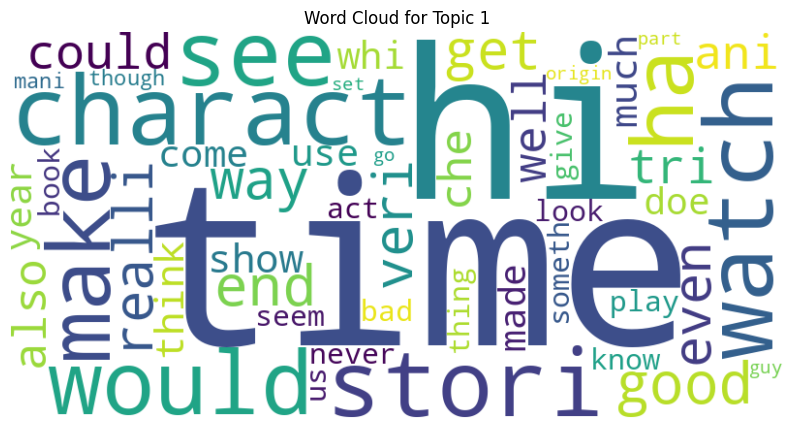

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud for a specific topic
def generate_wordcloud_for_topic(lda_model, topic_id, num_words):
    # Get the top words for the specified topic
    topic_words = lda_model.show_topic(topic_id, topn=num_words)

    # Prepare the words and their probabilities for the word cloud
    word_freq = {word: prob for word, prob in topic_words}

    # Generate the word cloud with the specified word frequencies
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(f"Word Cloud for Topic {topic_id+1}")
    plt.show()

# Example: Generate word cloud for Topic 1
generate_wordcloud_for_topic(model_10, topic_id=0, num_words=50)


#### Print reviews most associated with a single topic

Finally we can print out the reviews that are most associated with a single topic. Therefore, we first define a function to get the reviews per topic.

*Run the code below.*

In [17]:
#define a function to get the reviews per topic
def get_reviews_by_topic(model, corpus, reviews, topic_id, threshold=0.5):
    selected_reviews = []

    # Iterate over the corpus and their corresponding document-topic distributions
    for doc_idx, doc_topics in enumerate(model.get_document_topics(corpus)):
        # Check the contribution of the specified topic
        for topic, proportion in doc_topics:
            if topic == topic_id and proportion >= threshold:
                selected_reviews.append(reviews['text'].iloc[doc_idx])
                break  # Stop checking other topics for this document

    return selected_reviews

We can then apply the defined function to get the reviews for one specific topic. In this case, we will have a closer look at Topic 1 (the topic_id for Topic 1 is '0').

*Run the code below.*

In [18]:
#filtering on one specific topic ID and apply the function
topic_id = 0
reviews_for_topic = get_reviews_by_topic(model_10, corpus_train, X_train, topic_id, threshold=0.5)

# Limit the number of reviews displayed to 10
reviews_to_display = reviews_for_topic[:10]

#print the reviews so that we can read them
print(f"Topic:{topic_id+1}\n")
for review in reviews_to_display:
    print(f"{review}\n")
    print("-" * 80)  # Separator line for better readability

Topic:1

Kay Pollack (the man behind this movie) is a real great man who tries to share his life philosophy in different ways. He has written a bunch of good and well written books about how to control your senses and keep your soul happy. The message in most of his books and this movie, is about that your thoughts in fact is what causes your problems and that the reason of your anger hardly ever is caused of what you think of. The main message is that you can choose to be happy, but hardly ever do that.<br /><br />To watch this movie and learn something very important on life, you have to keep your mind very open and L I S T E N to all the \"hidden messages\" (or guidelines to get through life) which most of the parts in this movie contains if you listen and watch. Watch it with your ears.<br /><br />You won't learn the meaning of life, but you'll learn how to live and get the most out of it...<br /><br />So, while watching, please keep in mind:<br /><br />\"The mind is like a parachu

## Supervised Sentiment Analysis using Topic Modeling Features

In the previous section we learned how we can use topic modeling as an unsupervised method to analyse textual data. Now we will use the created topic model as an additional feature in our supervised Sentiment Analysis with the aim to classify reviews as either positive or negative.

### Store the per-document topic distributions in a dataframe for subsequent analysis.

Here, we define a function `get_document_topic_distribution` that takes an LDA model and a corpus as input. It retrieves the topic distribution for each document in the corpus, ensuring all topics are included even if their probability is zero (via `minimum_probability=0`). The function returns a  DataFrame where each row represents a document, and each column represents a topic's probability.

We then apply this function to both the training and test corpora using the trained `model_10`, creating `train_topic_distributions` and `test_topic_distributions` DataFrames. These DataFrames will serve as feature sets for our supervised classifiers.

**Why do we do this?** Topic modeling provides topic probabilities per document, which can be used as numerical features for machine learning models. By converting these distributions into DataFrames, we make them compatible with  classifiers for sentiment analysis.

*Run the code below.*

In [19]:
# Function to extract per-document topic distributions
def get_document_topic_distribution(model, corpus):
    """Get topic distributions for each document in a corpus."""
    return pd.DataFrame(
        [
            [prob for _, prob in model.get_document_topics(doc, minimum_probability=0)]
            for doc in corpus
        ],
        columns=[f'Topic{i+1}' for i in range(model.num_topics)]
    )

train_topic_distributions = get_document_topic_distribution(model_10, corpus_train)
test_topic_distributions = get_document_topic_distribution(model_10, corpus_test)

By displaying `train_topic_distributions`, we can now see for each review (each row) which topics are associated with it and how important each topic is (indicated by the probability values in the columns). This allows us to understand the topic composition of individual reviews.

In [20]:
train_topic_distributions

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,0.000569,0.000569,0.000569,0.000569,0.994883,0.000569,0.000569,0.000569,0.000569,0.000569
1,0.001391,0.078408,0.910467,0.001391,0.001391,0.001391,0.001391,0.001391,0.001391,0.001391
2,0.001409,0.443408,0.379900,0.001410,0.001410,0.001409,0.001410,0.001409,0.166826,0.001410
3,0.001251,0.001251,0.001251,0.988741,0.001251,0.001251,0.001251,0.001251,0.001251,0.001251
4,0.003851,0.965343,0.003851,0.003851,0.003851,0.003851,0.003851,0.003851,0.003851,0.003851
...,...,...,...,...,...,...,...,...,...,...
3995,0.001516,0.001516,0.001516,0.527301,0.001516,0.001516,0.001516,0.001516,0.460570,0.001516
3996,0.000856,0.039542,0.000856,0.266600,0.000856,0.000856,0.000856,0.000856,0.000856,0.687863
3997,0.182031,0.403987,0.001192,0.001192,0.001192,0.001192,0.001192,0.001192,0.001192,0.405642
3998,0.000599,0.165986,0.131952,0.000599,0.240309,0.000599,0.000599,0.000599,0.031017,0.427738


### Random Forest

#### Train random forest classifier

We train a random forest classifier on the training set (without hyperparameter tuning) to classify the sentiment based on the processed text features.

*Run the code below.*

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf_topicmodel = RandomForestClassifier(random_state=42).fit(train_topic_distributions, y_train)

#### Make predictions and calculate evaluation metrics on test set

Similarly to last week, we can make predictions on the test set and calculate different evaluation metrics.

*Run the code below.*

Accuracy (Random Forests): 0.633


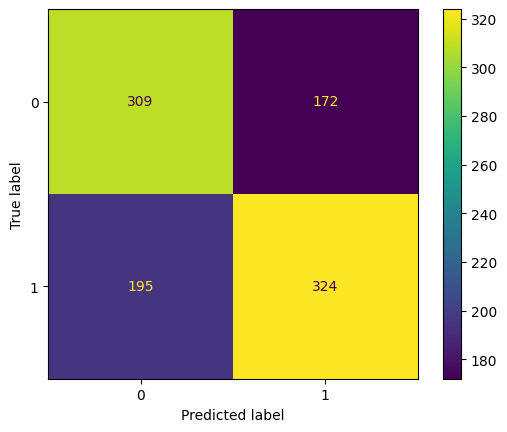

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

predictions_testset_rf_topicmodel = rf_topicmodel.predict_proba(test_topic_distributions)[:, 1]
predictions_testset_rf_topicmodel_binary = np.where(predictions_testset_rf_topicmodel > 0.5, 1, 0)

# Calculate Accuracy

accuracy_rf = accuracy_score(y_test, predictions_testset_rf_topicmodel_binary)
print("Accuracy (Random Forests):", accuracy_rf)

# Create the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_testset_rf_topicmodel_binary)

#### ROC and Auc

Plot ROC curve and calculate AUC on test set.
With __binary__ classification we get relatively straight lines. With the classification __probability__ we can map the distribution better. That is why we use the classification probability (e.g., predictions_testset_rf_topicmodel) to calculate the AUC.

*Run the code below.*

AUC Score: 0.6501388004278178


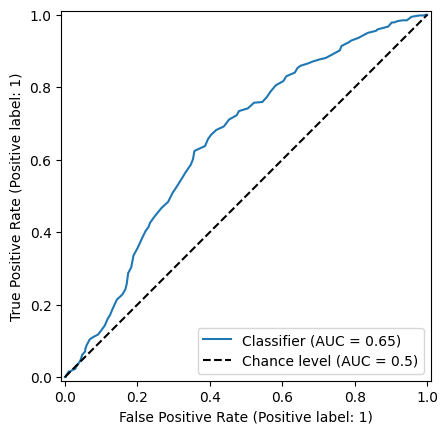

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_testset_rf_topicmodel)
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_testset_rf_topicmodel, plot_chance_level=True)

### CART

Instead of training a random forest we can also try out a basic decision tree and compare their performances. Therefor we simply grow a decision tree on the same training data as before and evaluate on the same test data.


### Train a simple classification tree and visualize it

*Run the code below.*

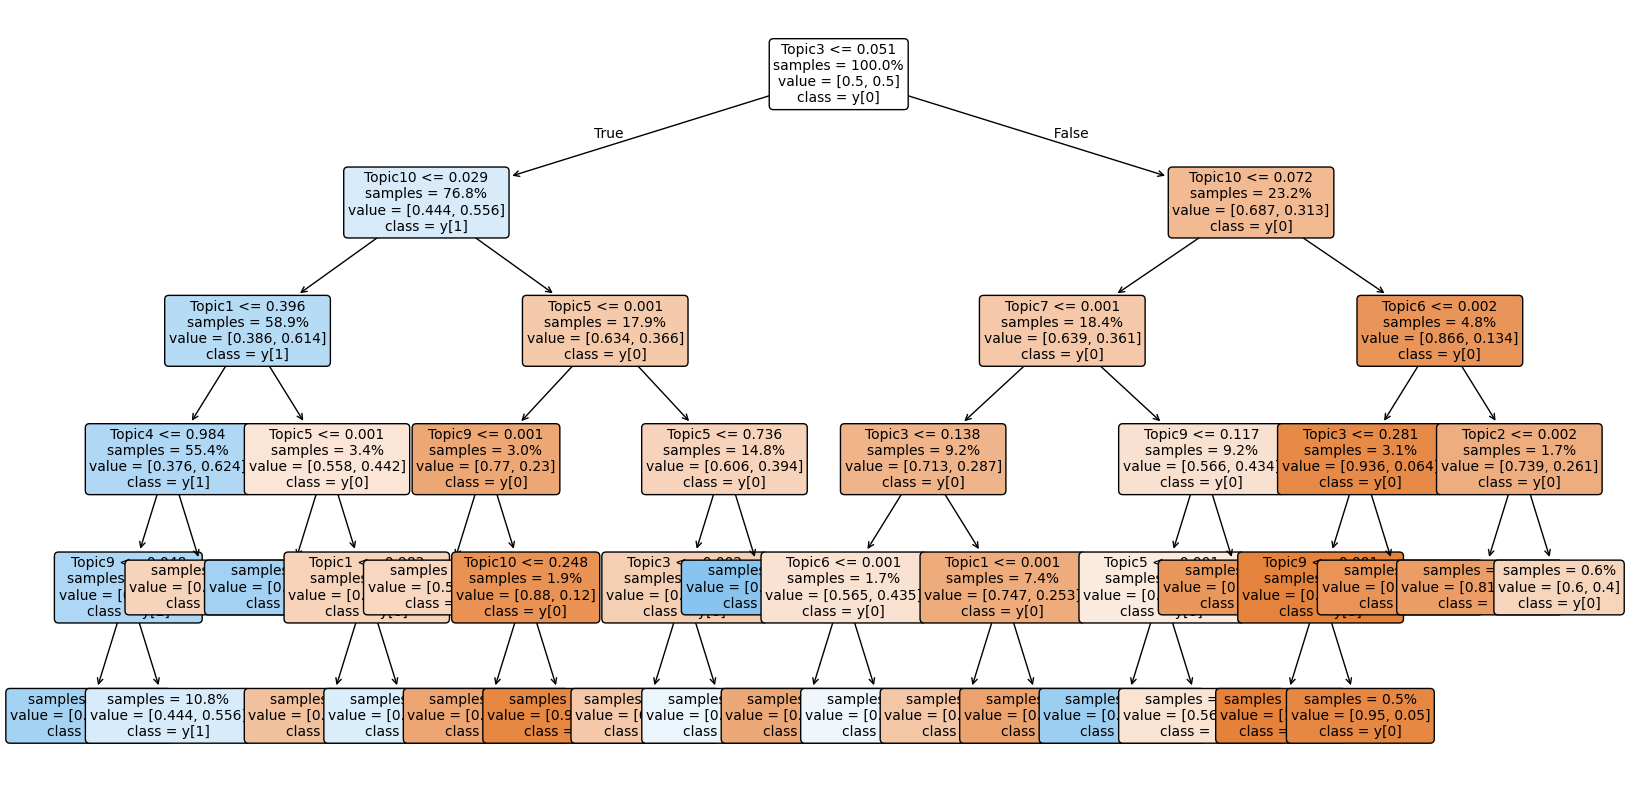

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train Decision Tree classifier
cart_topicmodel = DecisionTreeClassifier(min_samples_split=60, min_samples_leaf=20, max_depth=5, random_state=42).fit(train_topic_distributions, y_train)

# Visualize Decision Tree
plt.figure(figsize=(20,10))
plot_tree(cart_topicmodel, feature_names=train_topic_distributions.columns, impurity=False, filled=True, rounded=True, proportion=True, class_names=True, fontsize=10)
plt.show()

#### Make predictions and calculate evaluation metrics on test set

After calculating the decision tree's accuracy on the test set, we can see that there isn't a big difference in predictive performance, however the decision tree is a lot easier to interpret by a human compared to the random forest which is (without further analysis) a black box for us.

*Run the code below.*

Accuracy (Random Forests): 0.648


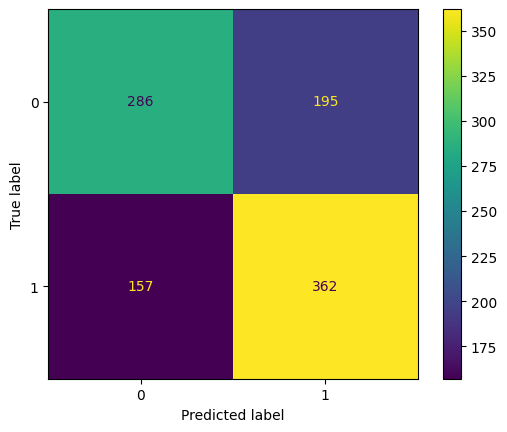

In [25]:
predictions_testset_cart_topicmodel = cart_topicmodel.predict_proba(test_topic_distributions)[:, 1]
predictions_testset_cart_topicmodel_binary = np.where(predictions_testset_cart_topicmodel > 0.5, 1, 0)

# Calculate Accuracy
accuracy_cart = accuracy_score(y_test, predictions_testset_cart_topicmodel_binary)
print("Accuracy (Random Forests):", accuracy_cart)

# Create the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_testset_cart_topicmodel_binary)

#### ROC and Auc

Plot ROC curve and calculate AUC on test set.
With __binary__ classification we get relatively straight lines. With the classification __probability__ we can map the distribution better. That is why we use the classification probability (e.g., predictions_testset_cart_topicmodel) to calculate the AUC.

*Run the code below.*

AUC Score: 0.6667988575503025


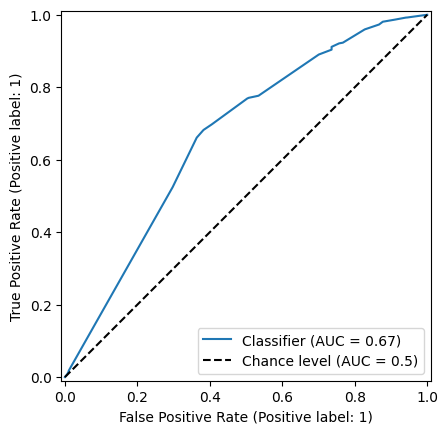

In [26]:
# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_testset_cart_topicmodel)
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_testset_cart_topicmodel, plot_chance_level=True)

## Summary

To sum it up let us have a look what we did in this week's tutorial:

+ First we learned how to use Topic Modeling as an unsupervised method to analyse textual data
+ Secondly we used the created topic model as an additional feature in our supervised Sentiment Analysis with the aim to classify reviews as either positive or negative

You can use the cell below to perform and evaluate different sentiment analyses

Accuracy (Random Forests): 0.572
AUC Score: 0.6031689760013459


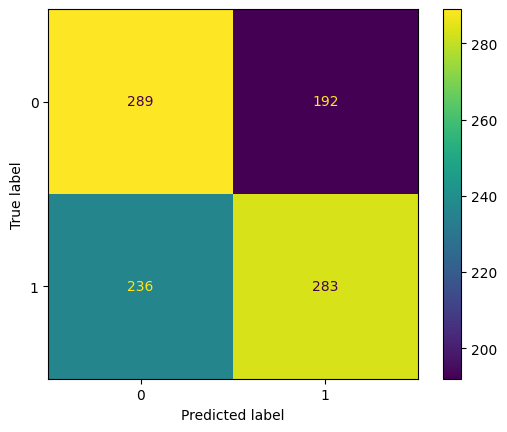

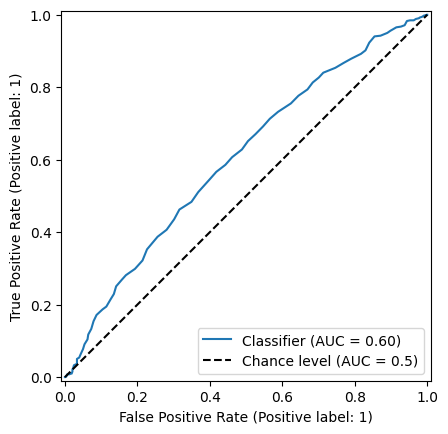

In [31]:
from nltk.stem import WordNetLemmatizer

# Enter your code here!
reviews['sentiment_positive'] = np.where(reviews['sentiment_human'] == 'positive', 1, 0)

#define X and y
X = reviews.drop(columns=['id','sentiment_human','sentiment_positive'])
y = reviews['sentiment_positive']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Define function with all necessary preprocessing steps for our IMDB reviews. As in week 9 we now use Stemming again.
def preprocess(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # create lemmatizer object
    lemmatizer = WordNetLemmatizer()

    # lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # get list of stopwords in English
    stopwords = nltk.corpus.stopwords.words("english")

    # remove stopwords
    filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stopwords]

    # remove punctuation. Here we use another kind of removing punctuation compared to last week. The Regex-based removal also removes punctuation attached to words (e.g., "hello," or "test.")
    filtered_tokens_nopunct = [re.sub(r'[^\w\s]', '', token) for token in filtered_tokens if token]

    return filtered_tokens_nopunct

# Apply text preprocessing
# Preprocess text data
X_train['tokens'] = X_train['text'].apply(preprocess)
X_test['tokens'] = X_test['text'].apply(preprocess)

# Remove additional irrelevant words (movie, film).
X_train['tokens'] = X_train['tokens'].apply(lambda tokens: [token for token in tokens if token not in {'movie', 'film'}])
X_test['tokens'] = X_test['tokens'].apply(lambda tokens: [token for token in tokens if token not in {'movie', 'film'}])

# Create dictionary and corpus for Gensim
dictionary = corpora.Dictionary(X_train['tokens'])
dictionary.filter_extremes(no_below=5)

#the corpus shows which token appears how often in one review which can be used as input for the Topic Model
corpus_train = [dictionary.doc2bow(text) for text in X_train['tokens']]
corpus_test = [dictionary.doc2bow(text) for text in X_test['tokens']]

# Train LDA model
k=12
model_12 = LdaModel(corpus=corpus_train, num_topics=k, id2word = dictionary, iterations=100, random_state=42)

# Get topic distributions
# Function to extract per-document topic distributions
def get_document_topic_distribution(model, corpus):
    """Get topic distributions for each document in a corpus."""
    return pd.DataFrame(
        [
            [prob for _, prob in model.get_document_topics(doc, minimum_probability=0)]
            for doc in corpus
        ],
        columns=[f'Topic{i+1}' for i in range(model.num_topics)]
    )

train_topic_distributions = get_document_topic_distribution(model_12, corpus_train)
test_topic_distributions = get_document_topic_distribution(model_12, corpus_test)

# Train a Random Forest classifier
rf_topicmodel = RandomForestClassifier(random_state=42).fit(train_topic_distributions, y_train)

predictions_testset_rf_topicmodel = rf_topicmodel.predict_proba(test_topic_distributions)[:, 1]
predictions_testset_rf_topicmodel_binary = np.where(predictions_testset_rf_topicmodel > 0.5, 1, 0)

# Calculate Accuracy

accuracy_rf = accuracy_score(y_test, predictions_testset_rf_topicmodel_binary)
print("Accuracy (Random Forests):", accuracy_rf)

# Create the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_testset_rf_topicmodel_binary)

# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_testset_rf_topicmodel)
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_testset_rf_topicmodel, plot_chance_level=True)